### Setup necessary packages

The easiest way to start running this notebook is to create an environment from the environment.yml file ([instructions](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file)).


In [1]:
import ipyleaflet as ipl
from ipywidgets import HTML
import seaborn as sns
from time import sleep
import networkx
import carinova_data as cd
import instance
import gomea
import pandas as pd
import osmnx as ox
ox.config(use_cache=True, log_console=True)


/Users/witoldtenhove/opt/anaconda3/envs/osmnx/lib/python3.8/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


### Inspect input data
The input data comes from an Excel file. Each row represents one care activity..

In [2]:
url = "test.xlsx"
source_df = pd.read_excel(url)

##########
## TEST ##
##########
source_df.head()

,Unnamed: 0,activity_id,client_nr,shift_id,duration,tw_start,tw_end,tw_bool,activity_level_name,activity_level,latitude,longitude
0,0,1,1f234b197528dc39cce623328f691629,0,5,NaN,NaN,0,PV 2+,2,52.269695,6.164124
1,1,2,8a8da03e273d26be7a26772ef5929985,0,5,NaN,NaN,0,PV 3,3,52.267812,6.175048
2,2,3,8a8da03e273d26be7a26772ef5929985,0,10,NaN,NaN,0,PV 2+,2,52.266598,6.168108
3,3,4,c89211489faa34db218a785da40f04fb,0,10,NaN,NaN,0,PV 2+,2,52.269764,6.176036
4,4,5,aaec17bd9a892dd25f796a35146f267c,0,15,NaN,NaN,0,PV 2+,2,52.267690,6.166916


### Read in data from Excel file

The `carinova_data.py` file contains functions for extracting and transforming the data. All the paths are hard coded in the `fetch_data()` function. The final output is a dictionary.

In [8]:
input_data = cd.fetch_data('city')
keys = input_data.keys()
items = input_data.items()
values = input_data.values()

##########
## TEST ##
##########
print(keys)

dict_keys(['n', 'v', 'p', 'd', 'tw', 'Q', 'u', 'ss', 'route', 'arrival', 'arrival_nobase', 'score', 'dist', 'wt', 'ot'])


### Get street network as graph
See documentation: https://github.com/gboeing/osmnx-examples

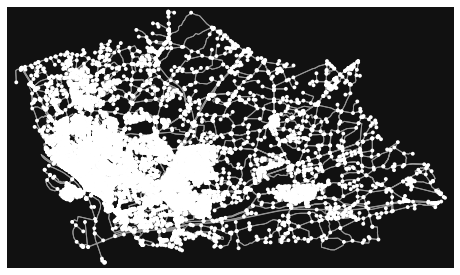

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [9]:

graph = ox.graph_from_place('Deventer, the Netherlands')

##########
## TEST ##
##########
ox.plot_graph(graph)


### Build Instance
The function containing the genetic algorithm needs an Instance `class`. This `class` takes in the first 8 variables of the dictionary as input.

In [10]:
n, v, p, d, tw, Q, u, ss = list(values)[:8]
ins = instance.Instance(n=n, v=v, p=p, d=d, tw=tw, Q=Q, u=u, ss=ss)

##########
## TEST ##
##########
ins.__dict__.keys()

dict_keys(['n', 'v', 'd', 'p', 'tw', 'Q', 'u', 'ss', 'feasibleShiftsForClients'])

### Solve for optimal routes
The function` gomea_solve()` contains the genetic algorithm. It requires an Instance object and returns a dictionary.

In [11]:
results = gomea.gomea_solve(ins)

##########
## TEST ##
##########
results.keys()

evolution cycle 0 finished in 0:00:18.480533
evolution cycle 1 finished in 0:00:18.325967
evolution cycle 2 finished in 0:00:19.017639
evolution cycle 3 finished in 0:00:18.797921
evolution cycle 4 finished in 0:00:19.066713
evolution cycle 5 finished in 0:00:19.123221
evolution cycle 6 finished in 0:00:18.620366
evolution cycle 7 finished in 0:00:18.853338
evolution cycle 8 finished in 0:00:18.225062
evolution cycle 9 finished in 0:00:18.136719
evolution cycle 10 finished in 0:00:19.105138
evolution cycle 11 finished in 0:00:18.201292
evolution cycle 12 finished in 0:00:18.237643
evolution cycle 13 finished in 0:00:18.023772
evolution cycle 14 finished in 0:00:18.519837
evolution cycle 15 finished in 0:00:17.783813
evolution cycle 16 finished in 0:00:17.754043
evolution cycle 17 finished in 0:00:18.054291
evolution cycle 18 finished in 0:00:18.444104


total elapsed time: 0:05:50.771412


dict_keys(['params', 'gen_count', 'time_track', 'route', 'arrival', 'score', 'distance', 'waiting_time', 'shift_overtime', 'progress', 'pop_means', 'instance'])

### Data dictionary
Before actually drawing the routes all the necessary data needs to be combined in a logical data structure. As the selected variables have different lengths (single values, lists) a suitable data type is a dictionary. The following functions takes in the source data, the output of the genetic algorithm, a street network and a the starting coordinates (latitude and longitude). It returns a dictionary containing all the data for building the maps and routes.

In [12]:
# Function combining data from source, gomea and street network into dictionary
def create_dict(source_df, gomea_dic, graph, base_location):
    # Initialize
    selection = ['activity_id', 'activity_level','latitude', 'longitude']
    source_data = source_df[selection]
    routes_dic = {}
    start = base_location
    gdf_nodes = ox.graph_to_gdfs(graph)[0]
    
    # For every route in gomea_dic create an entry in routes_dic with a route_id
    for rx, route in enumerate(gomea_dic['route']):
        location_dic = {}
        # For every location in the route create an entry with a location_id, a start location and a path list from start to location
        for lx, activity in enumerate(route):
            activity_id, activity_level, latitude, longitude = list(source_data[source_data['activity_id'] == activity].iloc[0])
            location_dic[lx] = {'route_id': rx,
                                'activity_id': activity_id,
                                'activity_level': activity_level,
                                'start': start,
                                'location': [latitude, longitude]
                                }
            y1, x1 = start
            y2, x2 = location_dic[lx]['location']
            nodes = ox.nearest_nodes(G=graph, X=[x1, x2], Y=[y1, y2])
            path_nodes = networkx.shortest_path(graph, nodes[0], nodes[1])
            path_coord = gdf_nodes.loc[path_nodes][['x', 'y']]
            path = []
            for point in path_coord.values:
                path.append([point[1], point[0]])
                location_dic[lx]['path'] = path
                
            # Set new start location
            start = location_dic[lx]['location']
            
        routes_dic[rx] = location_dic
    return(routes_dic)
            

##########
## TEST ##
##########
routes_dict = create_dict(source_df=source_df, gomea_dic=results, graph=graph, base_location=[52.27, 6.17])
routes_dict[0]


{0: {'route_id': 0,
  'activity_id': 58.0,
  'activity_level': 2.0,
  'start': [52.27, 6.17],
  'location': [52.26743000759968, 6.160593671904917],
  'path': [[52.2698226, 6.1705944],
   [52.2694548, 6.1694873],
   [52.2692228, 6.1697437],
   [52.2687504, 6.1702158],
   [52.2686794, 6.1700194],
   [52.2682494, 6.1688681],
   [52.2682204, 6.16879],
   [52.2679168, 6.1679964],
   [52.2678045, 6.1676908],
   [52.2677236, 6.1674846],
   [52.2676823, 6.1673673],
   [52.2676379, 6.1672594],
   [52.2675988, 6.1671432],
   [52.2674713, 6.1672624],
   [52.2672911, 6.1668008],
   [52.2671474, 6.1664099],
   [52.2670099, 6.1660538],
   [52.2667, 6.16521],
   [52.2677442, 6.1640739],
   [52.2674581, 6.1633258],
   [52.2672161, 6.1626088],
   [52.2667557, 6.1610283],
   [52.26763, 6.16136]]},
 1: {'route_id': 0,
  'activity_id': 36.0,
  'activity_level': 2.0,
  'start': [52.26743000759968, 6.160593671904917],
  'location': [52.26715118687354, 6.161267590928635],
  'path': [[52.26763, 6.16136], [52.

### Visualize routes
The quality of the calculated routes can be assessed by plotting them on a map. Each client can be plotted as a point and given a color depending on the route_id.

In [17]:
n_colors = len(routes_dict)
colors = sns.color_palette("Set2", n_colors).as_hex()

route_id = 3

route_dict_flr = routes_dict[route_id]

# Calculate map center and set bounds
latitudes = pd.Series(dtype="float64")
longitudes = pd.Series(dtype="float64")
for point in route_dict_flr.values():
    lat, lon = pd.Series([point["location"][0]]), pd.Series([point["location"][1]])
    latitudes = pd.concat([latitudes, lat])
    longitudes = pd.concat([longitudes, lon])
center = [latitudes.mean(), longitudes.mean()]
sw = [latitudes.min(), longitudes.min()]
ne = [latitudes.max(), longitudes.max()]
m1 = ipl.Map(center=center)
m1.fit_bounds([sw, ne])
m1.layout.height = '800px'

# Build route layer
trace = []
for point in route_dict_flr.values():
    for path in point["path"]:
        trace.append(path)
lines = ipl.Polyline(
    locations=trace,
    color="tomato",
    fill=False
)
m1.add_layer(lines)

# Build client locations layer
base = list(route_dict_flr.values())[0]
start = ipl.Circle(
    location=base["start"],
    radius=30,
    color="DimGray",
    fill_color="Skyblue",
    fill=True,
    fill_opacity=1
)
m1.add_layer(start)

for client in route_dict_flr.values():
    fill_color = colors[int(client["route_id"])]
    circle = ipl.Circle(
        location=client["location"],
        radius=20,
        color="DimGray",
        fill_color=fill_color,
        fill=True,
        fill_opacity=0.85,
        popup=HTML(str(client["activity_id"]))
    )
    m1.add_layer(circle)
    
# Add marker
mark = ipl.Marker(location=base["start"])
m1.add_layer(mark)

m1

Map(center=[52.26936066396481, 6.172080386149438], controls=(ZoomControl(options=['position', 'zoom_in_text', …

### Animation
The the actual sequence of visits can be shown using an animated agent that travels through the plotted route.

In [18]:
step = 0.1
for stage in route_dict_flr.values():
    for point in stage["path"]:
        mark.location = point
        sleep(step)
    visited = ipl.Circle(
        location=stage["location"],
        radius=20,
        color="#00b521",
        fill_color="#7fff96",
        fill=True,
        fill_opacity=0.85
    )
    m1.add_layer(visited)